<a href="https://colab.research.google.com/github/neupane11/CyberResearchDarknet/blob/main/darknet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIC Darknet 2020

We will be using the darknet dataset from Canada Institute of Cyber Security. Our goal is to work with the data to categorize darknet traffic. 

Steps we will take include:
1. Load data
2. Analyze data
   1. Cleaning the data
   2. Data Analysis
3. Visualize data
4. Split data into train-test set
5. Train and test a handful of models
6. Select the best model
7. Deploy the best model


# Importing Dataset


In [5]:
import pandas as pd
import numpy as np
import os
from google.colab import drive

To use the files in Google Collab, we need to follow these steps for each person.

1. Go to 'Shared with me/Cyber Research/Darknet' in your google drive
2. Right click the 'Experiments' Folder
3. Select 'Add shortcut to Drive'

This way, the code down below will work for you too!

In [6]:
!pwd
# Mounting your personal drive so we can use the csv file in our 'Code' folder
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Code'
%ls

/content
Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1kC6SnjfhH2sLMBa10QWH927CWRlISCq2/Code
Darknet.CSV  darknet.ipynb


In [7]:
df = pd.read_csv('Darknet.CSV', index_col='Timestamp', parse_dates=True)

# Analyzing Dataset

In [8]:
# First look at the data 
df

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,...,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label1
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-07-24 16:09:48,10.152.152.11-216.58.220.99-57158-443-6,10.152.152.11,57158,216.58.220.99,443,6,229,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.000000,8733.624454,229.00000,0.000000,229,229,0,0.00000,0.000000,0,0,0,0.00000,0.000000,0,0,0,0,0,0,20,...,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,1892,1047,0,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
2015-07-24 16:09:48,10.152.152.11-216.58.220.99-57159-443-6,10.152.152.11,57159,216.58.220.99,443,6,407,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.000000,4914.004914,407.00000,0.000000,407,407,0,0.00000,0.000000,0,0,0,0.00000,0.000000,0,0,0,0,0,0,20,...,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,1987,1047,0,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
2015-07-24 16:09:48,10.152.152.11-216.58.220.99-57160-443-6,10.152.152.11,57160,216.58.220.99,443,6,431,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.000000,4640.371230,431.00000,0.000000,431,431,0,0.00000,0.000000,0,0,0,0.00000,0.000000,0,0,0,0,0,0,20,...,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,2049,1047,0,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
2015-07-24 16:09:48,10.152.152.11-74.125.136.120-49134-443-6,10.152.152.11,49134,74.125.136.120,443,6,359,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.000000,5571.030641,359.00000,0.000000,359,359,0,0.00000,0.000000,0,0,0,0.00000,0.000000,0,0,0,0,0,0,20,...,0,0.000000,0.00000,0.000000,2,0,0,0,2,0,0,0,1,0.000000,0.000000,0.0000,0,0,0,0,0,0,0,0,0,0,2008,1047,0,20,0,0,0,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Non-Tor,AUDIO-STREAMING
2015-07-24 16:09:45,10.152.152.11-173.194.65.127-34697-19305-6,10.152.152.11,34697,173.194.65.127,19305,6,10778451,591,400,64530,6659,131,0,109.187817,22.283313,498,0,16.6475,46.833714,6604.752390,91.942711,10887.32424,11412.466410,78158,13,10778451,18268.56102,11786.143090,81171,126,10747836,26936.93233,15897.738450,78158,307,1,0,0,0,11820,...,498,71.876008,56.93647,3241.761603,1,0,0,659,991,0,0,0,0,71.948537,109.187817,16.6475,0,0,0,0,659,6605,0,65,0,6,1382,2320,581,20,0,0,0,0,1.437760e+15,3.117718e+06,1.437760e+15,1.437760e+15,Non-Tor,AUDIO-STREAMING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [9]:
# Here we can see the dimensions of the data
df.shape

(141530, 84)

In [10]:
# Showing a general stats for the data
df.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Total Fwd Packet,Total Bwd packets,Total Length of Fwd Packet,Total Length of Bwd Packet,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Fwd Bytes/Bulk Avg,Fwd Packet/Bulk Avg,Fwd Bulk Rate Avg,Bwd Bytes/Bulk Avg,Bwd Packet/Bulk Avg,Bwd Bulk Rate Avg,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,FWD Init Win Bytes,Bwd Init Win Bytes,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,141530.000000,141530.000000,141530.000000,1.415300e+05,141530.000000,141530.000000,1.415300e+05,1.415300e+05,141530.000000,141530.000000,141530.000000,141530.000000,141530.000000,141530.000000,141530.000000,141530.000000,1.414830e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05,141530.000000,141530.0,141530.0,141530.0,1.415300e+05,1.415300e+05,1.415300e+05,141530.000000,141530.000000,141530.000000,141530.000000,141530.000000,1.415300e+05,141530.000000,141530.000000,141530.000000,141530.000000,141530.000000,141530.0,141530.0,141530.0,141530.000000,141530.000000,141530.000000,141530.000000,141530.0,141530.0,141530.0,141530.0,141530.000000,1.415300e+05,141530.000000,141530.000000,141530.0,141530.000000,141530.000000,141530.000000,141530.000000,141530.000000,141530.0,141530.0,141530.0,141530.0,1.415300e+05,1.415300e+05,1.415300e+05,1.415300e+05
mean,38450.268819,18124.647333,10.350427,2.081280e+07,152.800749,154.642062,1.126211e+05,1.304530e+05,208.920420,15.617078,69.594959,63.974203,229.971299,41.252194,107.286657,65.183434,inf,inf,2.604871e+06,3.217701e+06,9.893961e+06,9.079030e+05,1.976846e+07,4.101510e+06,2.590150e+06,9.198071e+06,2.481004e+06,1.663278e+07,3.054588e+06,2.205417e+06,7.408141e+06,1.617510e+06,0.099562,0.0,0.0,0.0,2.933009e+03,3.099272e+03,6.321814e+03,4574.665230,14.365604,323.627316,94.373958,108.474093,5.488104e+04,0.455691,0.462284,0.038571,61.523168,268.251749,0.0,0.0,0.0,0.607214,108.900008,69.594959,107.286657,0.0,0.0,0.0,0.0,158.869455,4.521801e+04,0.286745,43.128022,0.0,55.488568,5308.189670,1766.762411,96.881573,15.808182,0.0,0.0,0.0,0.0,7.028030e+14,5.526137e+13,7.305885e+14,5.994078e+14
std,19124.801990,22202.197159,5.431807,3.809155e+07,2378.323352,3418.715287,3.251357e+06,4.566180e+06,649.432333,31.312298,219.965954,168.646012,786.736861,100.785013,240.511916,193.995126,NaN,NaN,7.124917e+06,7.753864e+06,1.968518e+07,5.665210e+06,3.765663e+07,1.145549e+07,7.138834e+06,1.921286e+07,1.049675e+07,3.590770e+07,1.036402e+07,6.824438e+06,1.801633e+07,9.098340e+06,0.299416,0.0,0.0,0.0,4.752686e+04,6.995175e+04,3.558899e+04,21380.969146,23.951595,966.025271,190.563975,207.640840,7.933552e+05,0.556133,0.844423,0.342543,807.239077,5342.816116,0.0,0.0,0.0,12.497544,197.306424,219.965954,240.511916,0.0,0.0,0.0,0.0,3042.371342,1.046669e+06,0.452243,137.725733,0.0,134.367698,9895.622577,7563.995687,1582.814902,7.110714,0.0,0.0,0.0,0.0,7.058710e+14,1.930165e+14,7.248202e+14,7.138287e+14
min,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.00

In [11]:
# Let's see what we will be categorizing data into
print(df.groupby('Label').size())

Label
Non-Tor    93356
NonVPN     23863
Tor         1392
VPN        22919
dtype: int64


In [12]:
print(df.groupby('Label1').size())

Label1
AUDIO-STREAMING     1484
Audio-Streaming    16580
Browsing           32808
Chat               11478
Email               6145
File-Transfer      11098
File-transfer         84
P2P                48520
VOIP                3566
Video-Streaming     9486
Video-streaming      281
dtype: int64


## Cleaning Data

### Options with cleaning data (add to list if think of something)

* #### $X^2$ test would be **SUPER helpful**
  * Basically a chi squared tells us what columns are effective with our machine learning algorithms later
  * If col isn't helpful, we can remove those columns from our data to make the algorithms later faster
* #### Label encoding
  * We aren't working with strings, just integers
  * We have a lot of IP addresses and other strings
  * Would run much faster if we can convert those to unique integers with a key
* #### Put ideas here

### First Approach

There are misspelling of data in Label1, so here we fix that. After that, we want relabel the classifing columns so it's easier to understand. 

In [13]:
# Fixing misspelled data in Label1 column

df['Label1'] = df['Label1'].str.lower()
df.Label1.unique()

array(['audio-streaming', 'browsing', 'chat', 'email', 'file-transfer',
       'p2p', 'video-streaming', 'voip'], dtype=object)

If a column has only one unique value, we don't need to keep that. Here is how we removed those.

In [14]:
def DropSingleValueColumns():
    threshold = 1
    # get number of unique values for each column
    print(df.shape)
    for col in df.columns:  # Loop through columns
        if len(df[col].unique()) <= threshold:  # Find unique values in column along with their length and if len is == 1 then it contains same values
            df.drop([col], axis=1, inplace=True)  # Drop the column
    print(df.shape)

DropSingleValueColumns()

(141530, 84)
(141530, 69)


Next, we removed duplicated rows.

In [15]:
# See if rows has duplicate data
df.drop_duplicates(inplace=True)
print(df.shape)

(117048, 69)


Now, we will remove strings, nan and inf values.


In [16]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

print(df.shape)

(116999, 69)


### $X^2$ Test

In [17]:
# Import for normalization
from sklearn.preprocessing import MinMaxScaler
# Import chi2 function 
from sklearn.feature_selection import chi2
print("Chi^2 imports complete")

Chi^2 imports complete


# Feature Selection

First off, we will start by creating our 'y' variable which will be used in classification. Our 'y' will contain information on whether the data is Darknet or Non-Darknet.

The data has classifications for Non-Tor or Tor combined with Non-VPN or VPN. When trying to classify what sort of traffic is in darknet, we want to combine VPN and Tor as "Darknet" with the rest being "Non-Darknet".

In [18]:
# We can use the 'apply' function in pandas to do this really easily

df['Label_dark'] = df['Label'].apply(lambda x: '1' if x == 'VPN' or 
                                     x == 'Tor' else '0')

y = df.Label_dark
y.unique()

array(['0', '1'], dtype=object)

In [19]:
# Now, we are grabbing the column names to use as our X

X = df.columns.tolist()

# Visualization of Data

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
%matplotlib inline

In [21]:
# # Creating pandas series for count of labels
# label_count = df.Label.value_counts()

# # Now plotting the count
# plt.figure(figsize=(10,8))
# sns.set_style('whitegrid')
# plt.title('Types of Traffic In Dataset')
# sns.barplot(x=label_count.index, y=label_count)
# plt.ylabel('Count')
# plt.xlabel('Type of Traffic')

Text(0.5, 0, 'Type of Traffic')

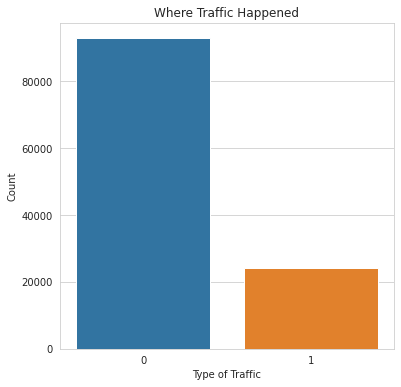

In [22]:
# Creating pandas series for count of label1

label3_count = df.Label_dark.value_counts()
label3_count

plt.figure(figsize=(6,6))
sns.set_style('whitegrid')
plt.title('Where Traffic Happened')
sns.barplot(x=label3_count.index, y=label3_count)
plt.ylabel('Count')
plt.xlabel('Type of Traffic')

Text(0.5, 0, 'Type of Traffic')

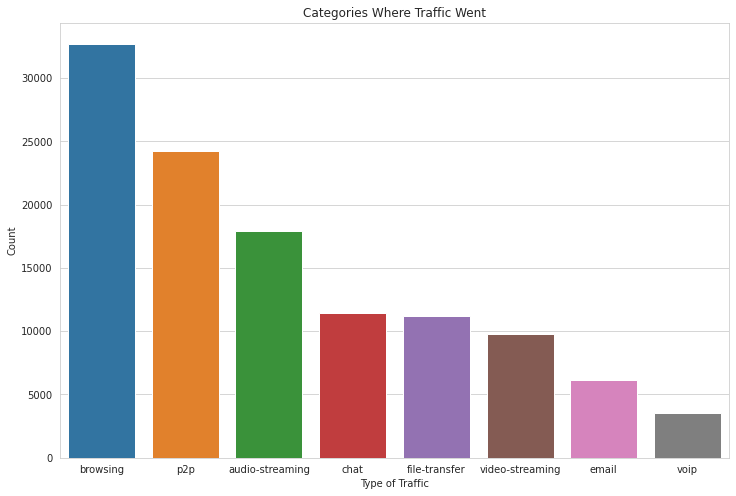

In [23]:
# Creating pandas series for count of label1
label1_count = df.Label1.value_counts()
label1_count

plt.figure(figsize=(12,8))
sns.set_style('whitegrid')
plt.title('Categories Where Traffic Went')
sns.barplot(x=label1_count.index, y=label1_count)
plt.ylabel('Count')
plt.xlabel('Type of Traffic')

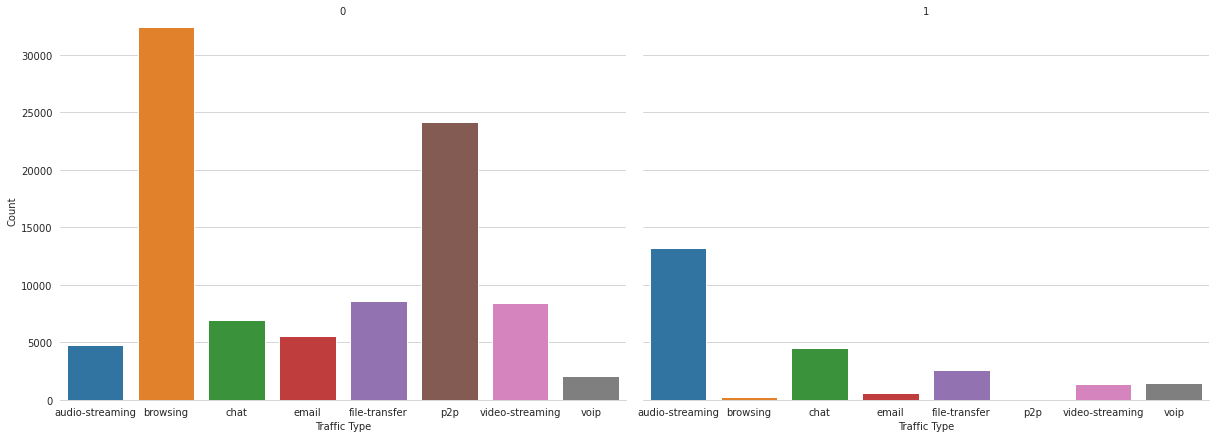

In [24]:
# Group plot of traffic depending on darknet or non-darknet

sns.set_style('whitegrid')
g = sns.catplot(x='Label1', col='Label_dark',
                data=df, kind='count', 
                height=6, aspect = 1.4)
(g.set_axis_labels("Traffic Type", "Count")
  .set_titles("{col_name}")
  .set(ylim=(0,33000))
  .despine(left=True))  

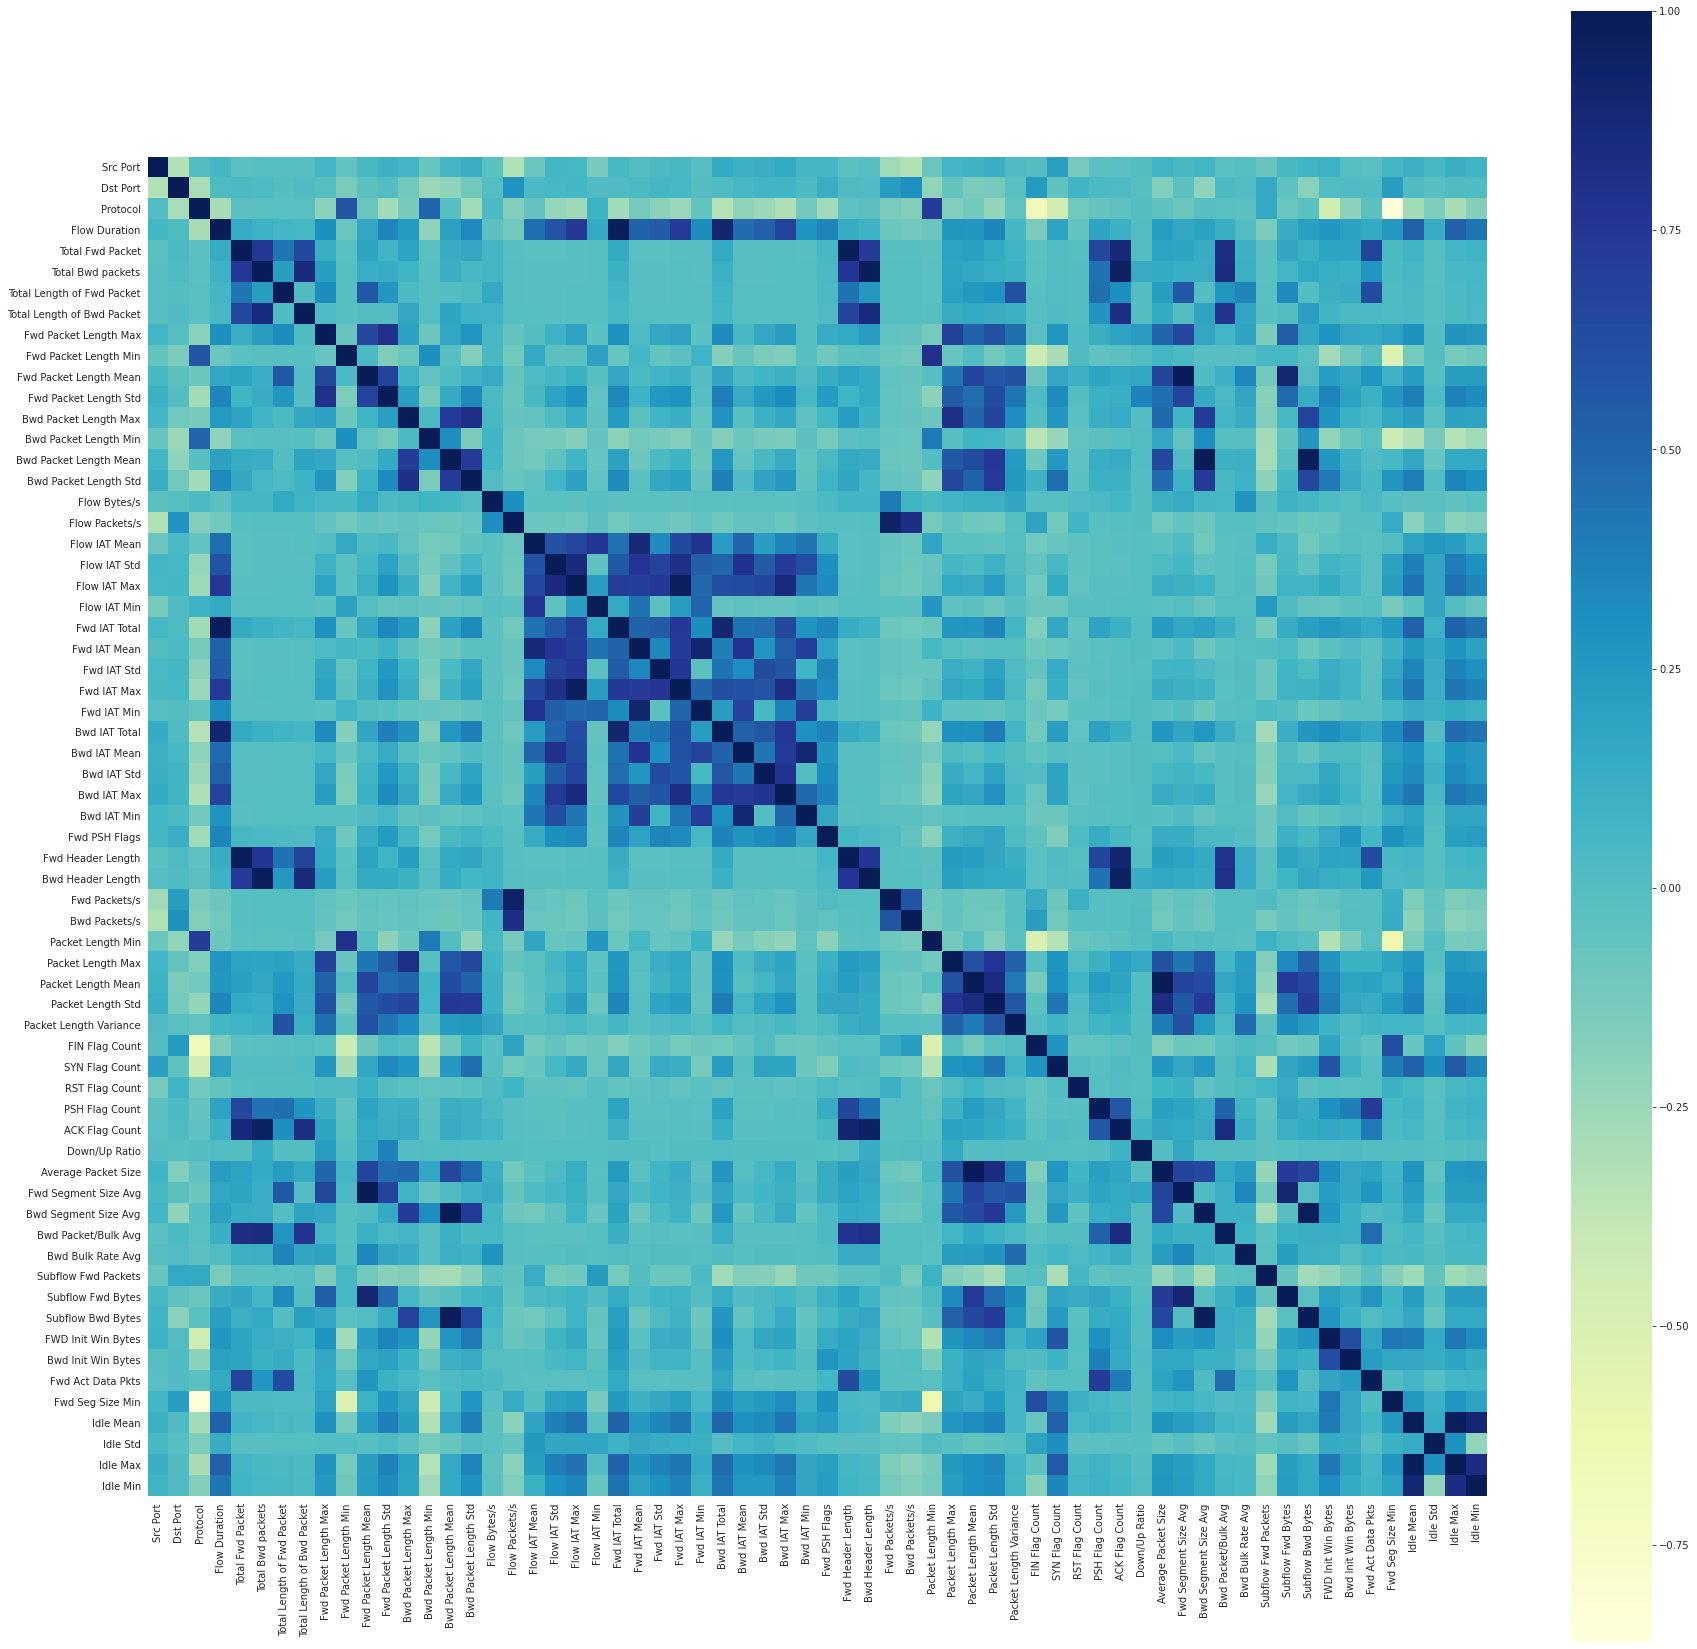

In [25]:
# Correllation

correlation = df.corr()
plt.figure(figsize =(30,30))
sns.heatmap(correlation, vmax=1, square=True, cmap='YlGnBu')

Here we can see our data is unbalanced. We can apply SMOTE(Synthetic Minority Over-sampling Technique)to overcome this. 

In [42]:
pd.options.display.max_columns=None
pd.options.display.max_rows=None
df.dtypes

Flow ID                        object
Src IP                         object
Src Port                        int64
Dst IP                         object
Dst Port                        int64
Protocol                        int64
Flow Duration                   int64
Total Fwd Packet                int64
Total Bwd packets               int64
Total Length of Fwd Packet      int64
Total Length of Bwd Packet      int64
Fwd Packet Length Max           int64
Fwd Packet Length Min           int64
Fwd Packet Length Mean        float64
Fwd Packet Length Std         float64
Bwd Packet Length Max           int64
Bwd Packet Length Min           int64
Bwd Packet Length Mean        float64
Bwd Packet Length Std         float64
Flow Bytes/s                  float64
Flow Packets/s                float64
Flow IAT Mean                 float64
Flow IAT Std                  float64
Flow IAT Max                    int64
Flow IAT Min                    int64
Fwd IAT Total                   int64
Fwd IAT Mean

In [87]:
#col=['Flow ID','Src IP', 'Dst IP']
#df.drop(col,inplace=True,axis=1)

In [88]:
df.dtypes

Src Port                        int64
Dst Port                        int64
Protocol                        int64
Flow Duration                   int64
Total Fwd Packet                int64
Total Bwd packets               int64
Total Length of Fwd Packet      int64
Total Length of Bwd Packet      int64
Fwd Packet Length Max           int64
Fwd Packet Length Min           int64
Fwd Packet Length Mean        float64
Fwd Packet Length Std         float64
Bwd Packet Length Max           int64
Bwd Packet Length Min           int64
Bwd Packet Length Mean        float64
Bwd Packet Length Std         float64
Flow Bytes/s                  float64
Flow Packets/s                float64
Flow IAT Mean                 float64
Flow IAT Std                  float64
Flow IAT Max                    int64
Flow IAT Min                    int64
Fwd IAT Total                   int64
Fwd IAT Mean                  float64
Fwd IAT Std                   float64
Fwd IAT Max                     int64
Fwd IAT Min 

In [26]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Splitting Data into Training and Testing

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from random import sample

In [28]:
# Splitting into training and testing data sets

train, test, validate = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
print(train.shape, test.shape, validate.shape)

(70199, 70) (23400, 70) (23400, 70)


In [29]:
# Now, splitting into classification labels and data
y_train = train['Label_dark']
x_train = train.drop(['Label_dark','Label', 'Label1'], axis=1)
x_train = x_train.select_dtypes(exclude=['object'])

y_test = test['Label_dark']
x_test = test.drop(['Label_dark','Label', 'Label1'], axis=1)
x_test = x_test.select_dtypes(exclude=['object'])

y_validate = validate['Label_dark']
x_validate = validate.drop(['Label_dark','Label', 'Label1'], axis=1)
x_validate = x_validate.select_dtypes(exclude=['object'])

In [49]:
print(y_train.value_counts())

0    55787
1    14412
Name: Label_dark, dtype: int64


In [69]:
sm = SMOTE(random_state=42)

x_sm, y_sm = sm.fit_resample(x_train, y_train)

print(f'''Shape of X before SMOTE: {x_train.shape}
Shape of X after SMOTE: {x_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
#y_sm.value_counts(normalize=True) * 100
unique, counts = np.unique(y_sm, return_counts=True)

dict(zip(unique, counts))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Shape of X before SMOTE: (70199, 64)
Shape of X after SMOTE: (111574, 64)

Balance of positive and negative classes (%):


{'0': 55787, '1': 55787}

We have a whole lot of columns right now. We want to remove as many of these to speed up our machine learning algorithm without hurting its accuracy. We will utilize the `DataFrame.feature_importances_` function for this.

In [43]:
# Here, we are showing how each feature's importance to the random forest

rf = RandomForestClassifier()
rf.fit(x_train, y_train)
importance = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), x_train), reverse=True)

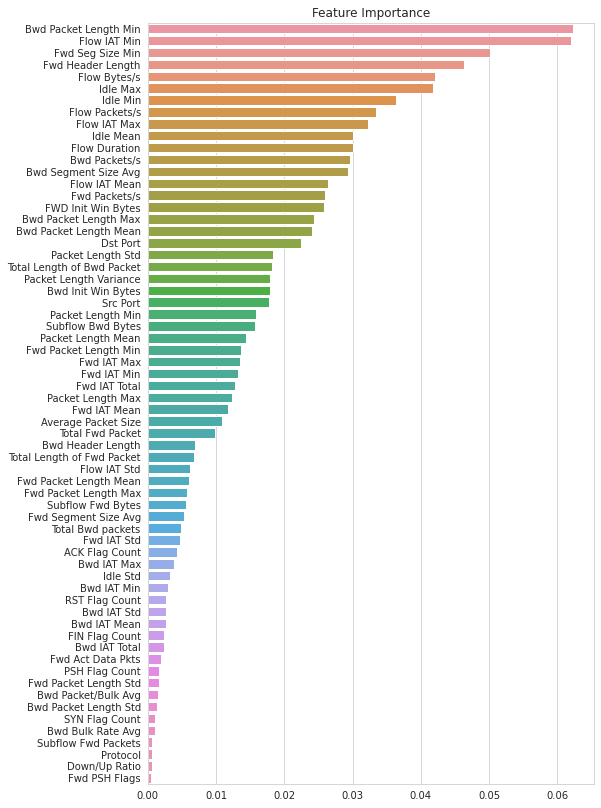

In [44]:
# Now, we plot the importance to see which columns we want to keep

labels = [row[1] for row in importance]
info = [row[0] for row in importance]
plt.figure(figsize=(8,14))
plt.title('Feature Importance')
sns.barplot(x = info, y= labels)

In [ ]:
# We want to use only a specific amout of the top features.

features = x_train.columns.tolist()
top_feat = [row[1] for row in importance[20]]
remove_features = [col for col in features if col not in top_feat]

x_train = x_train.drop(remove_features, axis=1)
x_test = x_test.drop(remove_features, axis=1)
x_validate = x_validate.drop(remove_features, axis=1)

# Classification

## Steps
1. Initialize the classifier
2. Train the classifier
3. Predict the target
4. Evaluate, find error

## Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [76]:
lr = LogisticRegression(random_state=0, solver='sag')
lr.fit(x_train, y_train)

print('Accuracy of training data', lr.score(x_train, y_train))

# Predicting for the testing data set
pred_y = pd.DataFrame(lr.predict(x_test))

probs = pd.DataFrame(lr.predict_proba(x_test))
print('Accuracy of testing data ', metrics.accuracy_score(y_test, pred_y))

Accuracy of training data 0.6493539794014159
Accuracy of testing data  0.6488034188034189


In [65]:
print(metrics.confusion_matrix(y_test, pred_y))
print(metrics.classification_report(y_test, pred_y))

[[13527  5020]
 [ 3198  1655]]
              precision    recall  f1-score   support

           0       0.81      0.73      0.77     18547
           1       0.25      0.34      0.29      4853

    accuracy                           0.65     23400
   macro avg       0.53      0.54      0.53     23400
weighted avg       0.69      0.65      0.67     23400



Random Forest

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
model = RandomForestClassifier(n_estimators=100)
model.fit(x_sm , y_sm)
y_pred = model.predict(x_test)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[18190   357]
 [  198  4655]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     18547
           1       0.93      0.96      0.94      4853

    accuracy                           0.98     23400
   macro avg       0.96      0.97      0.96     23400
weighted avg       0.98      0.98      0.98     23400



Gradient Boosting

In [83]:
from sklearn.ensemble import GradientBoostingClassifier
model_GB = GradientBoostingClassifier(n_estimators=100)
model_GB.fit(x_sm , y_sm)
y_pred = model_GB.predict(x_test)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[17910   637]
 [  241  4612]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     18547
           1       0.88      0.95      0.91      4853

    accuracy                           0.96     23400
   macro avg       0.93      0.96      0.94     23400
weighted avg       0.96      0.96      0.96     23400



Ada Boost

In [85]:
from sklearn.ensemble import AdaBoostClassifier
model_ad = AdaBoostClassifier()
model_ad.fit(x_sm , y_sm)
y_pred = model_ad.predict(x_test)
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

[[17527  1020]
 [  341  4512]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     18547
           1       0.82      0.93      0.87      4853

    accuracy                           0.94     23400
   macro avg       0.90      0.94      0.92     23400
weighted avg       0.95      0.94      0.94     23400




# Working with data

### Next steps
1. Split data into a train set and a test set

**Timestamp**: Plot and Heatmap

See what time the traffic is higher.

**Feature correlation**